# Arewa Data Science Deep Learning with PyTorch Capstone Project - Group 5

## Emotion Recognition from Static Facial Images Using Transfer Learning and CNN Architectures

This notebook serves as the documenttion for the capstone project (group 5) for the Arewa Data Science Deep Learning with PyTorch Course.

We finetuned a Computer Vision model capable of emotion recognition from static facial images using the FER2013 dataset. We also deployed the model on Huggingface.

Note:
- Wandb is used to log all training metrics.

- We defined dataset-specific functions to assist with the process including a directory search function, a stratified sampling validation split function, and a custom training function that implements early stopping.

- Multiple versions were implemented before we settled on this version.

- This is not the original notebook where the training occured, but a rewritten one meant to document the process.

- The notebook was written in Kaggle. All paths need to be properly redefined if one wants to use it in a different environment. Same result will be obtained regardless.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torch.nn import functional as F
import torchvision.transforms as T

from typing import Dict, List, Tuple, Any
from tqdm.auto import tqdm

import wandb

In [2]:
# for torchinfo
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# Wandb set up
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lazymonster (lazymonster-my-company) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# for device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get the dataset from Kaggle

Here we load the full training  data and take a peek at one of them:

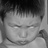

In [5]:
full_data = datasets.ImageFolder('/kaggle/input/fer2013/train')
full_data[0][0]

In [6]:
full_data.classes[full_data[0][1]]

'angry'

# Split the data into train and validation sets

To get a useful validation set, we have to perform a stratified split on the dataet. This is the only way the validation set would be balanced and properly representative of the dataset.

To do this, we choose the percentage we want for the validation set and randomly select that percentage from each label (folder), afterwards concatenating them together to form the new validation set.

We have written a function to do this.

The function takes in the following inputs:

- path (path string containing the training dataset)

- valid_pct (chosen percentage of data to use as validation)

- transforms (a list of transforms, one for the final training set and another for the final validation set)

- seed (random seed to ensure the same validation split over multiple runs)


The function works by going through the following steps:

- Read in the training data and create the dataset

- Create datasets for each class

- Store datasets in a list

- Iterate over the list of datasets

- In each iteration,

    - compute the train/val sizes
    - randomly select the appropriate number of images for the sets
    - add the train set to a train list, and the val set to a val list
- Concatenate the train list to a full train dataset and the val list to a full val dataset

In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, random_split, Dataset, ConcatDataset
from collections import defaultdict
import os

def fer_train_val(path, valid_pct, transforms, seed=42):

  # Step 1: Read data and create dataset
  dataset = ImageFolder(root=path, transform=transforms[0])

  # Step 2: Create datasets for each class:

  # - Mapping from class name to class index
  class_to_idx = dataset.class_to_idx
  idx_to_class = {v: k for k, v in class_to_idx.items()}

  # - Group indices by class (using string keys)
  class_indices = defaultdict(list)
  for i, (_, label) in enumerate(dataset.samples):
      class_indices[str(label)].append(i)

  # - Create a separate dataset for each class
  class_datasets = {}
  for class_idx_str, indices in class_indices.items():
      class_idx = int(class_idx_str)
      class_name = idx_to_class[class_idx]
      class_datasets[class_name] = Subset(dataset, indices)

  # Step 3: Store datasets in a list
  dataset_list = list(class_datasets.values())

  train_datasets = list()
  val_datasets = list()

  generator = torch.Generator().manual_seed(seed) # setting the random seed

  # Step 4: Loop through dataset_list and compute the validation and training sets
  for class_ds in dataset_list:
    val_size = int(valid_pct * len(class_ds))  # valid_pct% for validation
    train_size = len(class_ds) - val_size  # remaining% for training
    train_dataset, val_dataset = random_split(class_ds, [train_size, val_size], generator=generator)
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)

  # Step 5: Concatenate the datasets into train and val sets
  train = ConcatDataset(train_datasets)
  val = ConcatDataset(val_datasets)
  train.transform = transforms[0]
  val.transform = transforms[1]

  return train, val


## Model Training - Resnet18

### Load the model

In [8]:
from torchvision.models import resnet18, ResNet18_Weights

resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


### Preparing the model for fine tuning

After experimentation, we found that while the model trained faster if we froze its base layers, the accuracy was abysmal (starting from 33% and training up to 42% max), despite applying many transformations and optimizations. Compared to the iteration during which we applied no optimizations at all (starting from 64% and training up to 68%), it was much worse.

This led us to conclude that the top layer alone was not enough to accurately represent the dataset and understandably so. Resnet18 wasn't trained to distinguish between emotions and therefore would do poorly out of the box on the FER2013 dataset. To do better, we would need to fine-tune some of the base layers as well.

Let's take a look at the final fully connected layer:

In [9]:
resnet_model.fc

Linear(in_features=512, out_features=1000, bias=True)

It has 512 input features and 1000 output features, but we want it to output only 7 classes instead.

We therefore replace this last layer with our own layer which will output only 7 outputs (one for each of our classes).

In [10]:
# Get the number of input features for the final fully connected layer
num_ftrs = resnet_model.fc.in_features
num_classes = 7 # no of classes in our data

# Replace the final fully connected layer
resnet_model.fc = nn.Sequential(
    # First hidden layer (Input: num_ftrs, Output: 512 nodes)
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5), # Slightly higher dropout rate example

    # Second hidden layer (Input: 512, Output: 256 nodes)
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Apply dropout again

    # Output layer (Input: 256, Output: 7 classes)
    nn.Linear(256, 7)
)

# Move model to device
resnet_model.to(device)

# Look at the final layer again
resnet_model.fc

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=7, bias=True)
)

## Creating training and validation dataloaders

The resnet18 model is a pretrained model, so we have to transform our data into a form that is compatible with it. For example, the images in our dataset are grayscale (1 channel), but resnet18 was trained on 3-channel images.

These are the original transforms applied to the Resnet18 model:

In [11]:
# the original transforms for the model
ResNet18_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Let's define new transforms that would work well with the Resnet18 model. These are the transforms that we would use with our stratified split function, `fer_train_val`:

In [12]:
# ImageNet mean and std deviation (for 3 channels) - necessary because the pretrained model was trained with these
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
TARGET_SIZE = 224 # The spatial size expected by the pretrained ResNet-18 after transforms

# Transforms for the training set (includes augmentation)
train_transforms_resnet = T.Compose([
    T.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3 channels by repeating
    T.Resize(256),                      # Resize the image (typically the shorter side) to 256
    T.RandomCrop(TARGET_SIZE),          # Take a random 224x224 crop for data augmentation
    T.RandomHorizontalFlip(),           # Standard data augmentation
    T.RandomRotation(degrees=10),       # add slight rotation
    T.ColorJitter(brightness=0.2, contrast=0.2), # add brightness/contrast jitter
    T.ToTensor(),                       # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize with ImageNet values
])

# Transforms for the validation/testing set (deterministic preprocessing)
val_transforms_resnet = T.Compose([
    T.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3 channels
    T.Resize(256),                      # Resize the image (typically the shorter side) to 256
    T.CenterCrop(TARGET_SIZE),          # Take the central 224x224 crop for evaluation
    T.ToTensor(),                       # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize with ImageNet values
])


We get our train and val sets:

In [13]:
resnet_train, resnet_val = fer_train_val('/kaggle/input/fer2013/train', 0.2, [train_transforms_resnet,val_transforms_resnet])

Create the dataloaders:

In [14]:
batch_size = 32
resnet_trn_loader = DataLoader(resnet_train, batch_size=batch_size, shuffle=True, num_workers=2)
resnet_val_loader = DataLoader(resnet_val, batch_size=batch_size, shuffle=False, num_workers=2)

## Defining the training functions

The functions are defined below for modularity and ease of use. Early stopping has also been integrated into them to save computing resources and time.

In [15]:
import sys
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler: torch.optim.lr_scheduler.OneCycleLR) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. (added) Scheduler step
        scheduler.step()
        

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# EDITED FOR PERFORMANCE AND TO IMPLEMENT EARLY STOPPING

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, # Renamed from test_dataloader to val_dataloader for clarity with validation set
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          scheduler: torch.optim.lr_scheduler.OneCycleLR, # Type hint specific OneCycleLR as used
          device: torch.device,
          # --- Early Stopping Parameters ---
          patience: int = 10, # How many epochs to wait for improvement before stopping
          min_delta: float = 0.0 # Minimum change to qualify as improvement
          # ---------------------------------
         ) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model with Early Stopping.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop. Stops early if validation performance
    doesn't improve for 'patience' epochs.

    Calculates, prints and stores evaluation metrics throughout.
    Saves the best model state based on validation accuracy.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be validated on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for (maximum).
        scheduler: A PyTorch learning rate scheduler (assumed to be stepped per batch).
        device: A target device to compute on (e.g. "cuda" or "cpu").
        patience: Number of epochs to wait for improvement in validation accuracy.
        min_delta: Minimum change in validation accuracy to be considered an improvement.

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics tracked per epoch. The input 'model' object
        will be updated in-place with the best weights found during training
        (based on validation accuracy).
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [], # Renamed from test_loss to val_loss
               "test_acc": []  # Renamed from test_acc to val_acc
    }

    # --- Early Stopping Initialization ---
    best_val_accuracy = -float('inf') # Initialize best accuracy to a very low value
    patience_counter = 0             # Initialize patience counter
    best_model_state_dict = None     # To store the state_dict of the best model
    print(f"Early stopping configured with patience={patience}, min_delta={min_delta}")
    # ------------------------------------


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Assuming train_step includes scheduler.step() per batch
        train_loss, train_acc = train_step(model=model,
                                             dataloader=train_dataloader,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             device=device,
                                             scheduler=scheduler) # Pass scheduler

        # Assuming test_step is the validation step
        val_loss, val_acc = test_step(model=model, # Renamed test_step calls to clarify validation
                                          dataloader=test_dataloader, # Using test_dataloader as val_dataloader
                                          loss_fn=loss_fn,
                                          device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | " # Renamed print output
            f"val_acc: {val_acc:.4f}"     # Renamed print output
        )

        # --- Early Stopping Logic ---
        # Check for improvement in validation accuracy
        if val_acc > best_val_accuracy + min_delta:
            best_val_accuracy = val_acc
            patience_counter = 0 # Reset patience counter on improvement
            # Save the model state dictionary
            # Use copy.deepcopy() to save a true copy, not just a reference
            best_model_state_dict = deepcopy(model.state_dict())
            print(f"  Validation accuracy improved. Saving best model state (Acc: {best_val_accuracy:.4f})")
        else:
            patience_counter += 1 # Increment patience counter if no improvement
            print(f"  Validation accuracy did not improve. Patience: {patience_counter}/{patience}")

        # Check if early stopping condition is met
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break # Exit the training loop

        # --- End Early Stopping Logic ---
        # Log metrics to wandb
        run.log({"epoch": epoch+1,
               "train_loss": train_loss,
               "train_acc": train_acc,
               "test_loss": val_loss,
               "test_acc": val_acc})
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss) # Store as test_loss in results dict for consistency if needed later
        results["test_acc"].append(val_acc)   # Store as test_acc in results dict


    # --- Load the best model state after training stops ---
    if best_model_state_dict is not None:
        print("Loading best model state found during training.")
        model.load_state_dict(best_model_state_dict)
    else:
         print("No improvement was found during training. Using the model from the last epoch.")


    # Return the filled results at the end of the epochs
    return results

## Set up configuration

The `lr_find` function of Fastai is really good, so we use it here:

In [16]:
# importing fastai
from fastai.vision.all import *

# defining the DataLoaders object in FastAI using both train and val datasets
dls = DataLoaders(resnet_trn_loader, resnet_val_loader)

# wrapping our dataloader in a fastai learner
learn = Learner(
    dls, resnet_model,
    loss_func=CrossEntropyLossFlat(), 
    opt_func=SGD,
    metrics=accuracy
)

SuggestedLRs(valley=0.013182567432522774)


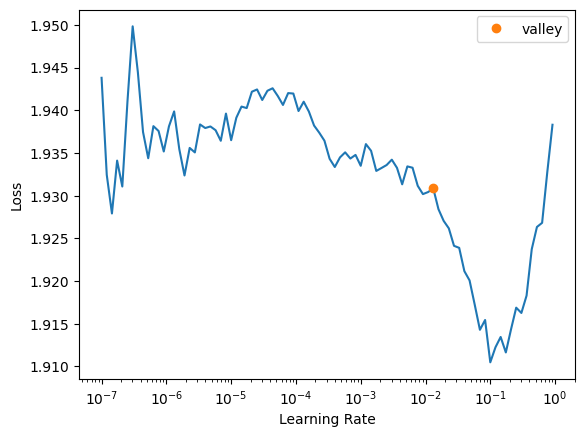

In [17]:
# finding the learning rate
lr_result = learn.lr_find()
print(lr_result)

In [18]:
lr = float(lr_result.valley)
lr

0.013182567432522774

In [19]:
# so we use that as our learning rate
learning_rate = lr

# define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# defining the optimizer, this time using SGD
optimizer = optim.SGD(
    resnet_model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4)

# define the number of epochs
num_epochs = 50

# adding a learning rate scheduler (OneCycleLR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    steps_per_epoch=len(resnet_trn_loader),
    epochs=num_epochs)


## Initialize Wandb

In [20]:

run = wandb.init(
    entity="lazymonster-my-company",
    # Set the wandb project where this run will be logged.
    project="FER2013 Documentation Training",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": lr,
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": num_epochs,
        "batch_size": batch_size
    },
)

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250603_123913-ffof4iwe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run deep-music-2
wandb: ⭐️ View project at https://wandb.ai/lazymonster-my-company/FER2013%20Documentation%20Training
wandb: 🚀 View run at https://wandb.ai/lazymonster-my-company/FER2013%20Documentation%20Training/runs/ffof4iwe


## Now, we train

In [21]:
# Set number of epochs again for clarity
num_epochs = 50 

# set patience value for early stopping
patience_value = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Call the training function with early stopping parameters
resnet18_results = train(model=resnet_model,
                         train_dataloader=resnet_trn_loader,
                         test_dataloader=resnet_val_loader,
                         optimizer=optimizer,
                         loss_fn=criterion,
                         epochs=num_epochs,
                         scheduler=scheduler,
                         device=device,
                         patience=patience_value,
                         min_delta=0.0001
                         )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Early stopping configured with patience=10, min_delta=0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6578 | train_acc: 0.3272 | val_loss: 1.3344 | val_acc: 0.4903
  Validation accuracy improved. Saving best model state (Acc: 0.4903)
Epoch: 2 | train_loss: 1.3015 | train_acc: 0.4983 | val_loss: 1.1632 | val_acc: 0.5480
  Validation accuracy improved. Saving best model state (Acc: 0.5480)
Epoch: 3 | train_loss: 1.1767 | train_acc: 0.5563 | val_loss: 1.0589 | val_acc: 0.5963
  Validation accuracy improved. Saving best model state (Acc: 0.5963)
Epoch: 4 | train_loss: 1.1035 | train_acc: 0.5916 | val_loss: 1.0337 | val_acc: 0.6192
  Validation accuracy improved. Saving best model state (Acc: 0.6192)
Epoch: 5 | train_loss: 1.0581 | train_acc: 0.6110 | val_loss: 1.0023 | val_acc: 0.6261
  Validation accuracy improved. Saving best model state (Acc: 0.6261)
Epoch: 6 | train_loss: 1.0369 | train_acc: 0.6178 | val_loss: 1.0209 | val_acc: 0.6308
  Validation accuracy improved. Saving best model state (Acc: 0.6308)
Epoch: 7 | train_loss: 1.0099 | train_acc: 0.6281 | val_lo

## Model testing

Now that we have trained the model, it is time to test the model on the test dataset.

First we load the data:

In [22]:
test_dataset = ImageFolder(root='/kaggle/input/fer2013/test', transform=val_transforms_resnet)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
)

In [23]:
from sklearn.metrics import classification_report

# Evaluate model
resnet_model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report as dictionary
report_dict = classification_report(
    all_labels, 
    all_preds, 
    target_names=full_data.classes, 
    output_dict=True
)

# Print report
print(classification_report(all_labels, all_preds, target_names=full_data.classes))

# Flatten and log to wandb
flattened_report = {}
for label, metrics in report_dict.items():
    if isinstance(metrics, dict):
        for metric_name, value in metrics.items():
            flattened_report[f"{label}/{metric_name}"] = value
    else:
        flattened_report[label] = metrics

# Log to wandb
run.log(flattened_report)

# Properly close the wandb session
run.finish()

              precision    recall  f1-score   support

       angry       0.61      0.63      0.62       958
     disgust       0.78      0.68      0.72       111
        fear       0.54      0.56      0.55      1024
       happy       0.89      0.87      0.88      1774
     neutral       0.65      0.64      0.64      1233
         sad       0.58      0.57      0.57      1247
    surprise       0.80      0.83      0.81       831

    accuracy                           0.69      7178
   macro avg       0.69      0.68      0.69      7178
weighted avg       0.70      0.69      0.69      7178



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               accuracy ▁
wandb:         angry/f1-score ▁
wandb:        angry/precision ▁
wandb:           angry/recall ▁
wandb:          angry/support ▁
wandb:       disgust/f1-score ▁
wandb:      disgust/precision ▁
wandb:         disgust/recall ▁
wandb:        disgust/support ▁
wandb:                  epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:          fear/f1-score ▁
wandb:         fear/precision ▁
wandb:            fear/recall ▁
wandb:           fear/support ▁
wandb:         happy/f1-score ▁
wandb:        happy/precision ▁
wandb:           happy/recall ▁
wandb:          happy/support ▁
wandb:     macro avg/f1-score ▁
wandb:    macro avg/precision ▁
wandb:       macro avg/recall ▁
wandb:      macro avg/support ▁
wandb:       neutral/f1-score ▁
wandb:      neutral/precision ▁
wandb:         neutral/recall ▁
wandb:        neutral/support ▁
wandb:        

## Save the model as a .pt file

In [24]:
torch.save(resnet_model.state_dict(), "./v3-resnet18.pt")

## Deployed on HuggingFace. Check it out!

The model has been deployed on Huggingface! Check it out [here](https://huggingface.co/spaces/lazymonster/facial-emotion-recognition)